In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.optimize as SciOpt
import sys
import toml
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
sys.path.append(os.path.join(sys.path[0], '../..'))

In [3]:
import endure.lsm.cost_model as CostFunc
from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
# from model.kcost import KCostModel
# from data.kcost_dataset import EndureDataPipeGenerator
# from model.tierlevelcost import TierLevelCost
# from lsm.lsmtype import Policy
# from jobs.train import TrainJob

In [4]:
config = Reader.read_config('../../endure.toml')

In [5]:
model_path = '/data/models/level-03-14-v1'
config_model = Reader.read_config(os.path.join(model_path, 'endure.toml'))

In [6]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

## Build Model and Cost Function

In [7]:
builder = LearnedCostModelBuilder(config_model)
model = builder.build_model()
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_20.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [8]:
cf = CostFunc.EndureLevelCost(config_model)

#### Utils

In [9]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [10]:
def calc_contribution(T):
    t_frac = T - np.floor(T)
    return ((np.floor(T), 1 - t_frac), (np.ceil(T), t_frac))

In [11]:
def sanitize_inputs(inputs: np.array):
    cont_inputs = (inputs[0:5] - config['lcm']['data']['mean_bias'])
    cont_inputs /= config['lcm']['data']['std_bias']
    
    cate_inputs = inputs[5:]
    cate_inputs[0] -= config['lsm']['size_ratio']['min']
    if len(cate_inputs) > 1:
        cate_inputs[1:] -= config['lsm']['size_ratio']['min'] - 1
    
    return np.concatenate((cont_inputs, cate_inputs))

In [12]:
def cost_func_learned_raw_eval(args, wl):
    h, T = args
    z0, z1, q, w = wl
    inputs = sanitize_inputs(np.array([z0, z1, q, w, h, T], np.float32))
    inputs = torch.from_numpy(inputs.reshape(1, -1)).float()
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item() 
    return pred

In [13]:
def cost_func_learned(args, wl):
    h, T, = args
    pairs = calc_contribution(T)
    val = 0
    for (t_prime, frac) in pairs:
        val += frac * cost_func_learned_raw_eval([h, t_prime], wl)
    return val

In [14]:
def cost_func_analytical(args, wl):
    h, T = args
    z0, z1, q, w = wl
    return cf(h, T, z0, z1, q, w)

In [15]:
args = [2, 10]
wl = [0.97, 0.01, 0.01, 0.01]
cost_func_learned(args, wl), cost_func_analytical(args, wl)

(0.7409916520118713, 0.6508262182442016)

## Loss Over Time

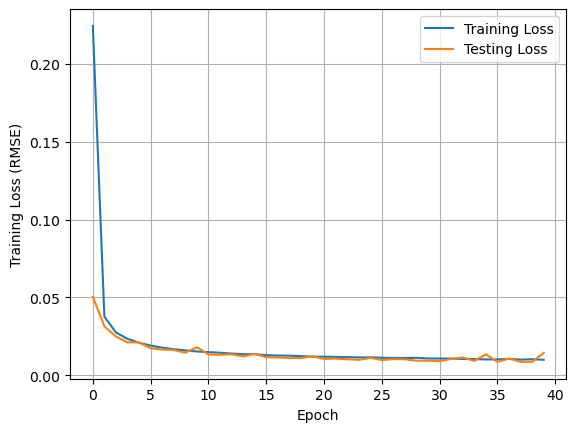

In [16]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config_model["job"]["LCMTrain"]["loss_fn"]})')
ax.grid()
_ = ax.legend()

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [17]:
def generate_single_var_estimation(workload):
    df = []
    h_fixed, t_fixed = 2, 10
    # for val in np.arange(2, 50, 1):
    #     x = [h_fixed, val]
    for val in np.arange(0, 9, 0.1):
        x = [val, t_fixed]
        df.append({
            'x': val,
            'learned': cost_func_learned_raw_eval(x, workload),
            'analytical': cost_func_analytical(x, workload)
        })
    return pd.DataFrame(df)

In [18]:
idx = 7
df = generate_single_var_estimation(to_array(config['workloads'][idx]))

{'id': 7, 'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}

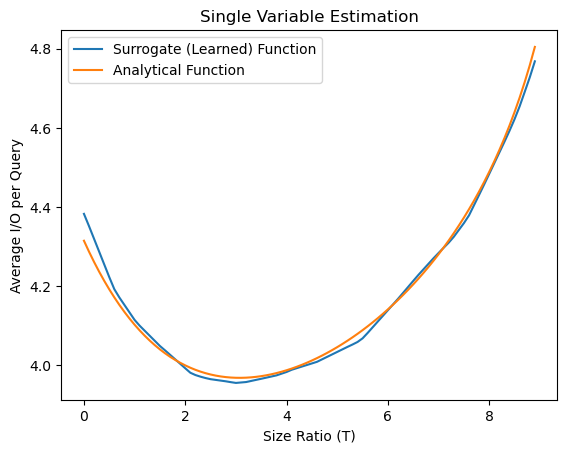

In [19]:
x = df['x']
y_learned = df['learned']
y_analytical = df['analytical']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
workload = config_model['workloads'][idx]
workload

### Histogram of Performance

In [23]:
wl = (0.062, 0.015, 0.910, 0.013)
h, T = (1.66, 45)

In [24]:
cost_func_learned_raw_eval([h, T], wl)

2.161817789077759